In [1]:
import numpy as np
from scipy import special
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
def U(X, means, sigmas, p):
    exp = torch.exp(-torch.cat([torch.pow(X - means[i], 2) / (2 * sigmas[i] ** 2) for i in range(len(means))], dim=1))
    coefs = p / (np.sqrt(2 * np.pi) * sigmas)
    return -torch.log(torch.matmul(exp, coefs))

In [3]:
p = torch.tensor([0.5, 0.5])
sigmas = torch.tensor([1., 1.])
means = torch.tensor([2, -2])

In [4]:
def mixture_sampler(means=[0], sigmas=[1], p=[1], size=1):
    sample = []
    for _ in range(size):
        i = np.random.choice(np.arange(len(p)), p=p)
        sample.append(np.random.normal(loc=means[i], scale=sigmas[i], size=1))
    return np.vstack(sample)

In [5]:
X = torch.tensor(mixture_sampler(means, sigmas, p.numpy(), 10000), dtype=torch.float32, requires_grad=True)
f_X = torch.pow(X, 3).squeeze()

In [6]:
def b(X, U_deriv, deg):
    poly1 = torch.vander(X.squeeze(), N=deg + 1)
    poly1 = poly1[:, :-1]
    second_term = torch.mul(poly1, U_deriv.reshape(-1, 1))
    first_term = torch.vander(X.squeeze(), N=deg)
    coef = torch.arange(deg, 0, -1, dtype=torch.float32).reshape(1, -1)
    first_term = torch.mul(first_term, coef)
    return first_term - second_term

In [7]:
def Learn(X, means, sigmas, p, deg=5):
  U_X = U(X, means, sigmas, p)
  X.grad = None
  U_X.sum().backward(retain_graph=True)
  U_X_prime = X.grad.squeeze()

  beshki = b(X, U_X_prime, deg) # deg = 5

  b_norm = beshki - torch.mean(beshki, dim=0)
  f = X**3
  f_norm = f - torch.mean(f)
  V = b_norm[:, :, None] @ b_norm[:, None, :]
  V /= V.shape[0] - 1
  V = V.sum(dim=0)
  b_norm *= f_norm.reshape(-1, 1)
  C = b_norm.T
  C /= C.shape[1] - 1
  C = C.sum(dim=1).reshape(-1, 1)
  V_inverse = torch.inverse(V)
  theta = V_inverse @ C

  g = beshki @ theta
  g_norm = g - torch.mean(g)
  l = f_norm - g_norm
  vr = (f - g).mean().item()

  return theta, l, vr

In [8]:
theta, l, _ = Learn(X, means, sigmas, p)

In [9]:
def Pi_f(means, sigmas, p):
    return (p * (torch.pow(means, 3) + 3 * means * torch.pow(sigmas, 2))).sum().item()

In [10]:
x = torch.tensor(np.linspace(-5, 5, 10000).reshape(-1, 1), dtype=torch.float32, requires_grad=True)

U_X = U(x, means, sigmas, p)
x.grad = None
U_X.sum().backward(retain_graph=True)
U_X_prime = x.grad.squeeze()
beshki = b(x, U_X_prime, 5) # deg = 5

g_x = beshki @ theta
g_x_numpy = g_x.detach().numpy()
x_numpy = x.detach().numpy()
pi_f = Pi_f(means, sigmas, p)

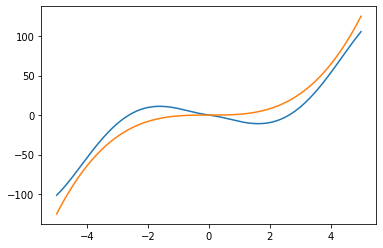

In [11]:
plt.plot(x_numpy, g_x_numpy)
f_numpy = x_numpy ** 3
plt.plot(x_numpy, f_numpy - pi_f);

In [12]:
estimates = []
vr_estimates = []
np.random.seed(42)

for i in range(100):
  X = torch.tensor(mixture_sampler(means, sigmas, p, 10000), dtype=torch.float32, requires_grad=True)

  U_X = U(X, means, sigmas, p)
  X.grad = None
  U_X.sum().backward(retain_graph=True)
  U_X_prime = X.grad.squeeze()

  f_X = torch.pow(X, 3).squeeze()
  estimates.append(f_X.mean().item())

  beshki = b(X, U_X_prime, 5) # deg = 5
  g = beshki @ theta
  vr = (f_X - g).mean().item()

  vr_estimates.append(vr)

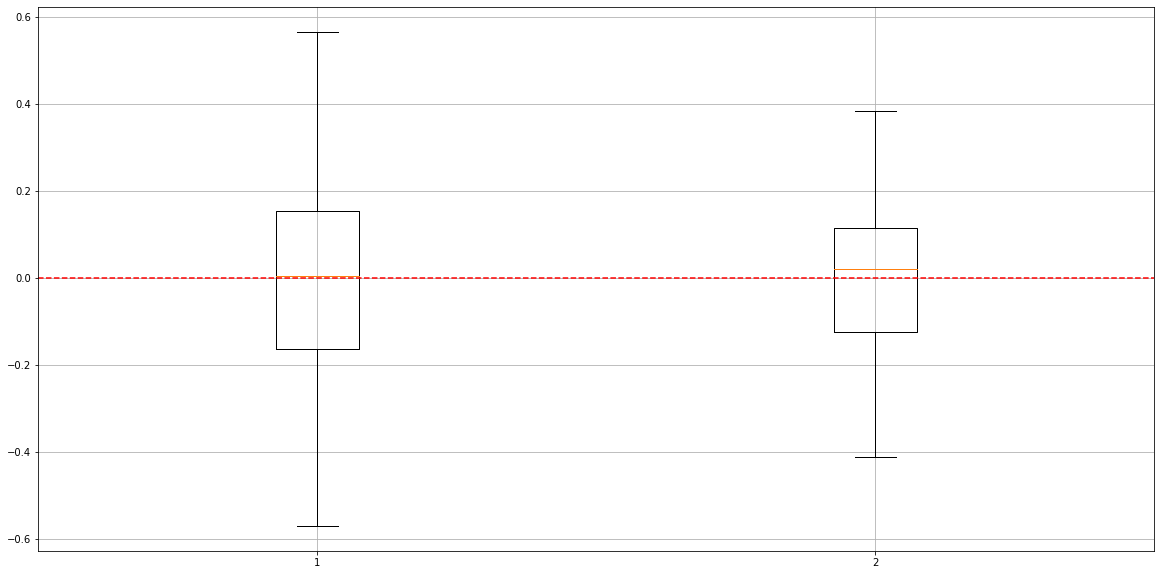

In [13]:
plt.figure(figsize=(20, 10))
plt.boxplot([estimates, vr_estimates])
plt.axhline(y=pi_f, color='r', linestyle='--')
plt.grid(True)

In [14]:
sample_theta = []
for _ in range(5):
    sample_theta.append(np.random.normal(loc=0.5, scale=2.0, size=1))
rand_theta = torch.tensor(np.vstack(sample_theta), dtype=torch.float32)
rand_theta -= torch.ones(rand_theta.shape[0]).reshape(-1, 1)
print(rand_theta)

tensor([[ 3.6268],
        [-2.3268],
        [-0.1479],
        [ 0.0429],
        [ 1.2351]])


In [15]:
estimates = []
np.random.seed(42)

for i in range(100):
  p = torch.tensor([0.5, 0.5])
  sigmas = torch.tensor([2., 1.])
  means = torch.tensor([-1., 2.])
  X = torch.tensor(mixture_sampler(means, sigmas, p, 10000), dtype=torch.float32, requires_grad=True)

  U_X = U(X, means, sigmas, p)
  X.grad = None
  U_X.sum().backward(retain_graph=True)
  U_X_prime = X.grad.squeeze()

  beshki = b(X, U_X_prime, 5)
  g = beshki @ rand_theta
  estimates.append(g.mean().item())

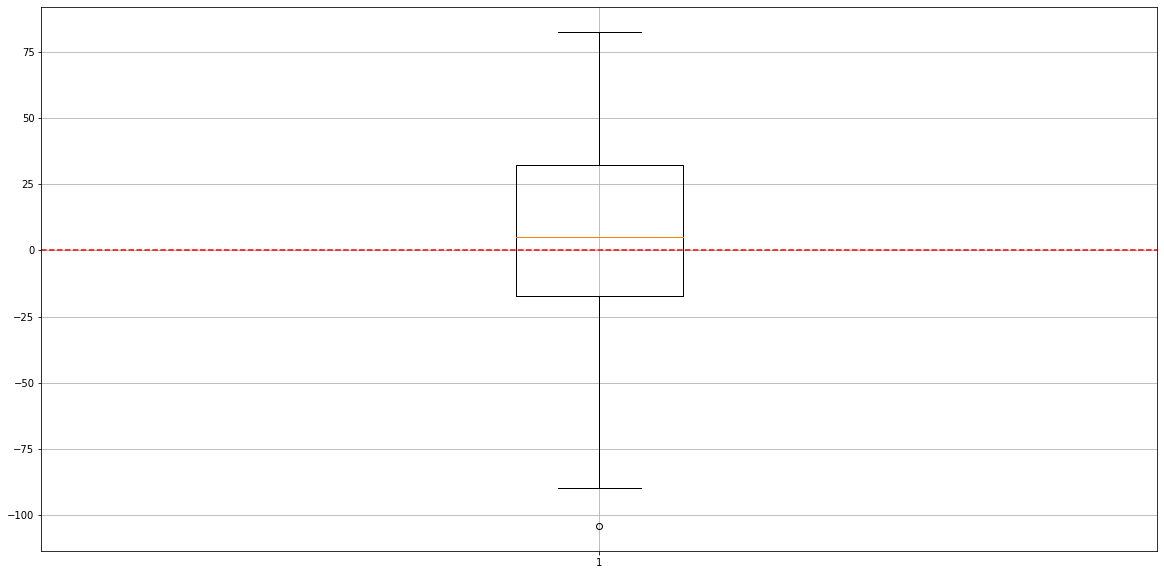

In [16]:
plt.figure(figsize=(20, 10))
plt.boxplot([estimates])
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)

In [41]:
a = [1, 2, 3, 4]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


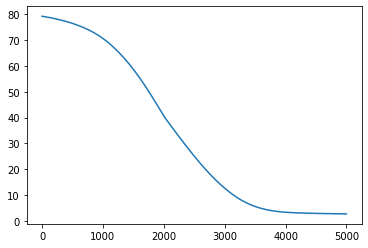

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


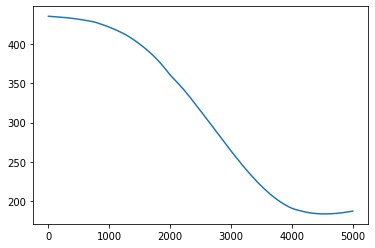

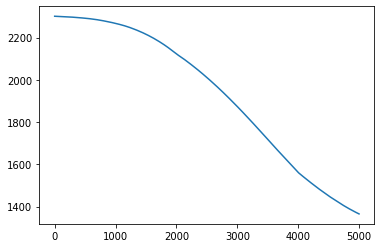

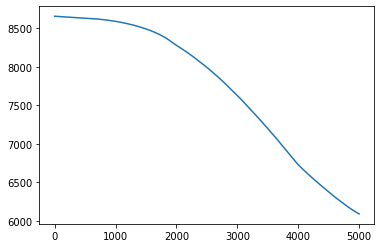

In [43]:
np.random.seed(42)
results_poly = []
results_nn = []
results_vanilla = []
pi_fs = []
fix_deg = 5
device = 'cpu'

for mean in a:
  p = torch.tensor([0.5, 0.5])
  sigmas = torch.tensor([1., 1.])
  means = torch.tensor([mean, -mean])

  X = torch.tensor(mixture_sampler(means, sigmas, p.numpy(), 1000), dtype=torch.float32, requires_grad=True)
  f_X = torch.pow(X, 3).squeeze()
  theta, l, _ = Learn(X, means, sigmas, p, fix_deg)
  pi_fs.append(Pi_f(means, sigmas, p))
  X.grad = None

  n_epoch = 5000
  Y = (f_X - torch.mean(f_X)).to(device)
  loss = nn.MSELoss()
  loss_history = []

  width = 16
  fucking_network = nn.Sequential(
      nn.Linear(1, width),
      nn.ReLU(),
      nn.Linear(width, width),
      nn.ReLU(),
      nn.Linear(width, width),
      nn.ReLU(),
      nn.Linear(width, width),
      nn.ReLU(),
      nn.Linear(width, 1),
  )
  fucking_network.to(device)
  optimizer = torch.optim.Adam(fucking_network.parameters(), lr=3e-5)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2000, gamma=0.8)

  for _ in tqdm_notebook(range(n_epoch)):
    phi_X = fucking_network(X.to(device)).squeeze()
    X.grad = None
    phi_X.to(device).sum().backward(retain_graph=True)
    phi_X_prime = X.grad.squeeze().to(device)
    U_X = U(X, means, sigmas, p).to(device)
    X.grad = None
    U_X.to(device).sum().backward(retain_graph=True)
    U_X_prime = X.grad.squeeze().to(device)
    g_X = -U_X_prime * phi_X + phi_X_prime
    Y_pred = (g_X - torch.mean(g_X)).to(device)
    train_loss = loss(Y_pred, Y).to(device)
    optimizer.zero_grad()
    train_loss.backward(retain_graph=True)
    optimizer.step()
    scheduler.step()
    loss_history.append(train_loss.item())
  
  plt.plot(loss_history) #plotting loss history
  plt.show()

  vr_estimates_nn = []
  vr_estimates_poly = []
  estimates = []
  for i in tqdm_notebook(range(100)):
    X = torch.tensor(mixture_sampler(means, sigmas, p.numpy(), 1000), dtype=torch.float32, requires_grad=True)

    U_X = U(X, means, sigmas, p)
    X.grad = None
    U_X.sum().backward(retain_graph=True)
    U_X_prime = X.grad.squeeze()

    f_X = torch.pow(X, 3).squeeze()
    estimates.append(f_X.mean().item())

    beshki = b(X, U_X_prime, fix_deg) # deg = 5
    g = beshki @ theta
    vr = (f_X - g).mean().item()
    vr_estimates_poly.append(vr)

    f_X = torch.pow(X, 3).squeeze()
    estimates.append(f_X.mean().item())
    phi_X = fucking_network(X.to(device)).squeeze()
    X.grad = None
    phi_X.to(device).sum().backward(retain_graph=True)
    phi_X_prime = X.grad.squeeze().to(device)
    U_X = U(X, means, sigmas, p).to(device)
    X.grad = None
    U_X.to(device).sum().backward(retain_graph=True)
    U_X_prime = X.grad.squeeze().to(device)
    g_X = -U_X_prime * phi_X + phi_X_prime
    vr_estimates_nn.append((f_X-g_X).mean().item())

  results_poly.append(vr_estimates_poly)
  results_vanilla.append(estimates)
  results_nn.append(vr_estimates_nn)

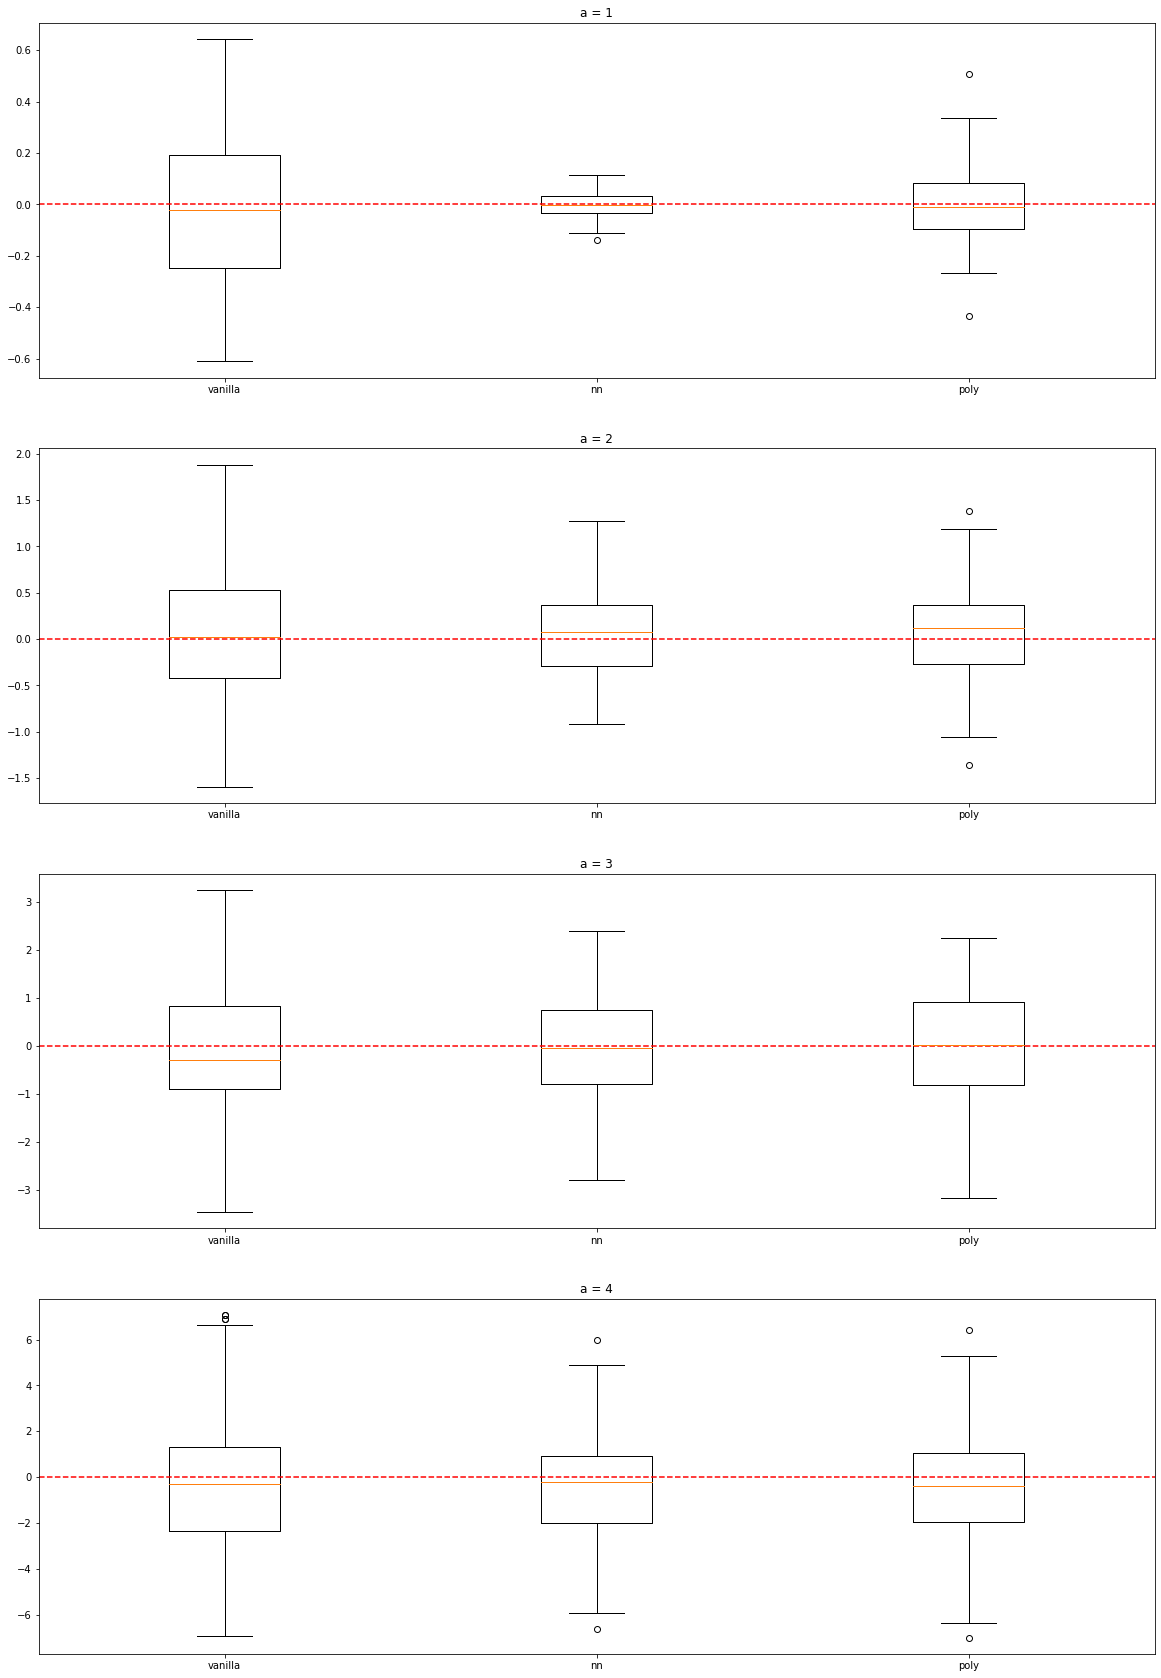

In [44]:
fig, axs = plt.subplots(4, 1, figsize=(20, 30))
for i, mean in enumerate(a):
  axs[i].boxplot([results_vanilla[i], results_nn[i], results_poly[i]], labels=["vanilla", "nn", "poly"])
  axs[i].axhline(y=pi_fs[i], color='r', linestyle='--')
  axs[i].set_title("a = {:d}".format(mean))